### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 12th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize

import corner

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Part 1

In [2]:
datadir = '../../../homeworks/hw_data/'
rawdata = np.load(datadir+'hw3_data_1.npy')
data = rawdata[:,0]
uncert = rawdata[:,1]


#Compute the sample mean
mean = np.average(data,weights=1/(np.square(uncert)))
#Made sure that the np.average() weighting needs 1/sigma^2
#m = np.sum(data/np.square(uncert))/np.sum(1/np.square(uncert))
print(f'Sample Mean: {mean}')


#Standard error
variance = 1/(len(data)-1) * np.sum(np.square(data-mean))
std_err_mean = np.sqrt(variance/len(data))
print(f"Error in the mean: {std_err_mean}")

Sample Mean: 3.917992034606056
Error in the mean: 0.1156684711875707


### Part 2
$$ p(y_i|x_i, M(a, b), \sigma_i) = N(y_i - M(x)|\sigma_i) = \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma_i^2} \right). $$

$$ p(y|x,M(a,b),\sigma) = \prod_i^N p(y_i|x_i, M(a,b),\sigma_i)$$

$$ ln(p) = ln(\prod_i^N\frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma_i^2} \right)) = \sum_i^N ln(\frac{1}{\sqrt{2 \pi \sigma_i^2}}) + ln(\exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma_i^2} \right)) $$
$$ ln(p) = \sum_i^N ln(\frac{1}{\sqrt{2 \pi \sigma_i^2}}) - \sum_i^N \left( \frac{(y_i - M(x_i))^2}{2 \sigma_i^2} \right) $$

Given this function, we now need to describe the model. Because we are assuming the noise is a gaussian around a specific mean, we can make the model a simple offset from 0, representing the mean of the distribution. This is the parameter we will maximize the likelihood for.

To maximize the ln(p), we can inspect each element and see that the first sum is the same with any value for a mean, this means that maximizing ln(p) will only deal with the second term. Similarly, as scipy's optimize functions minimize, we need to minimize -ln(p)

In [3]:
def neg_ln_p(mu,x=data,sig=uncert):
    #This is a constant term and is unimportant to the maximization but is here for continuity's sake
    term1 = np.sum(np.log(1/(np.sqrt(2*np.pi)*sig)))
    
    #This is for the important term, use : data-model=noise
    res_square = np.square(x-mu)
    term2 = np.sum(res_square/(2*np.square(sig)))
    
    #for maximizing ln(p) we need to minimize -ln(p) with scipy, hence the negative
    return -(term1 - term2)


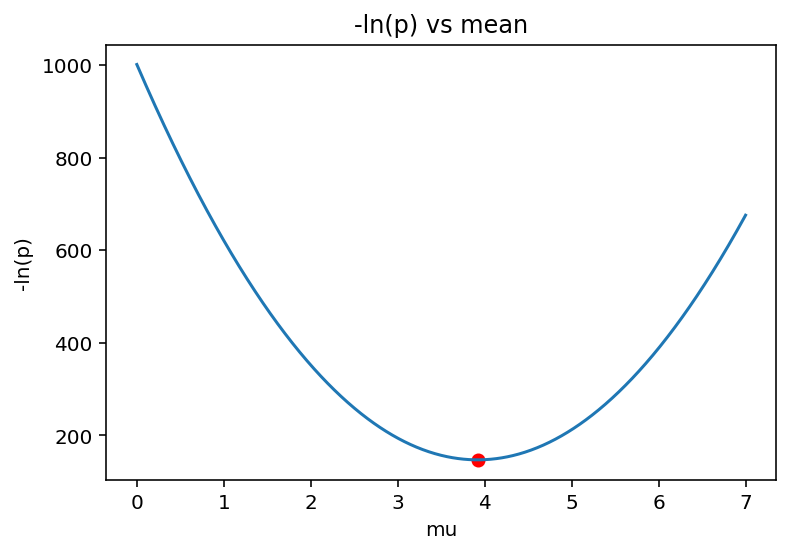

Optimized mean: 3.9179920290561956


In [4]:
guess=0
optimized_mu = minimize(neg_ln_p,guess).x

mu_grid = np.linspace(0,7,1000)
p = [neg_ln_p(mu) for mu in mu_grid]
plt.plot(mu_grid,p)
plt.scatter(optimized_mu,neg_ln_p(optimized_mu),c='r',marker='o')
plt.title('-ln(p) vs mean')
plt.xlabel('mu')
plt.ylabel('-ln(p)')
plt.show()
print(f"Optimized mean: {optimized_mu[0]}")

### Part 3
Using the following equation we can compute the uncertanty in the mean:
$$ F_{jk} = - \frac{\partial^2}{\partial\theta_j} \frac{\ln L}{\partial\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

and
$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

Since we only have one parameter, our matrix is 1x1 with j=k=1

Take second derivative using finite difference 
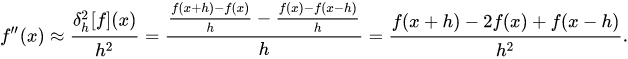(From wikipedia: https://en.wikipedia.org/wiki/Finite_difference)

In [5]:
#Since you only need second derivative at the point of highest likelyhood, only need mu and 4 closest neighbors
h=0.01
x = optimized_mu+np.array([-2*h,-h,0,h,2*h])
p = [neg_ln_p(i) for i in x]

#This operation helps approximate second derivative, BUT it chops off the first index for each n
#Hence getting dif2[0] is actually the second order difference at the x[2] datapoint. Thats our mean!
dif2 = np.diff(p,n=2)


#While F is technically the negative of the following, because I used the negative ln(p), I omit this
F = dif2[0]/np.square(h)

sigma = np.sqrt(1/(F))
print(f"Mean uncertainty from F: {sigma}")

Mean uncertainty from F: 0.09481084100522273


### Part 4

In [6]:
def bootstrapIndex(n_datapoints):
    return np.random.randint(0,high=n_datapoints,size=n_datapoints)

bootstrapData = []
bootstrapSigma = []
for i in range(1000):
    index = bootstrapIndex(len(data))
    
    #Need to pair data with uncertainty
    bootstrapData.append(data[index])
    bootstrapSigma.append(uncert[index])

bootstrapData = np.array(bootstrapData)
bootstrapSigma = np.array(bootstrapSigma)

### Part 5

In [7]:
#While the code here runs in a decently short amount of time, I KNOW it's unoptimized
#Ideally, I would be able to compute all mu values for each data set simultaneously using
#some of numpy's array features as parameters. However, because I set up my function neg_ln_p 
#to be more readable (i.e. easier to understand at a glance), I cannot use this feature.

muDist = []

for i in range(len(bootstrapData)):
    data = bootstrapData[i]
    sig = bootstrapSigma[i]
    
    muDist.append(minimize(neg_ln_p,0,args=(data,sig)).x[0])

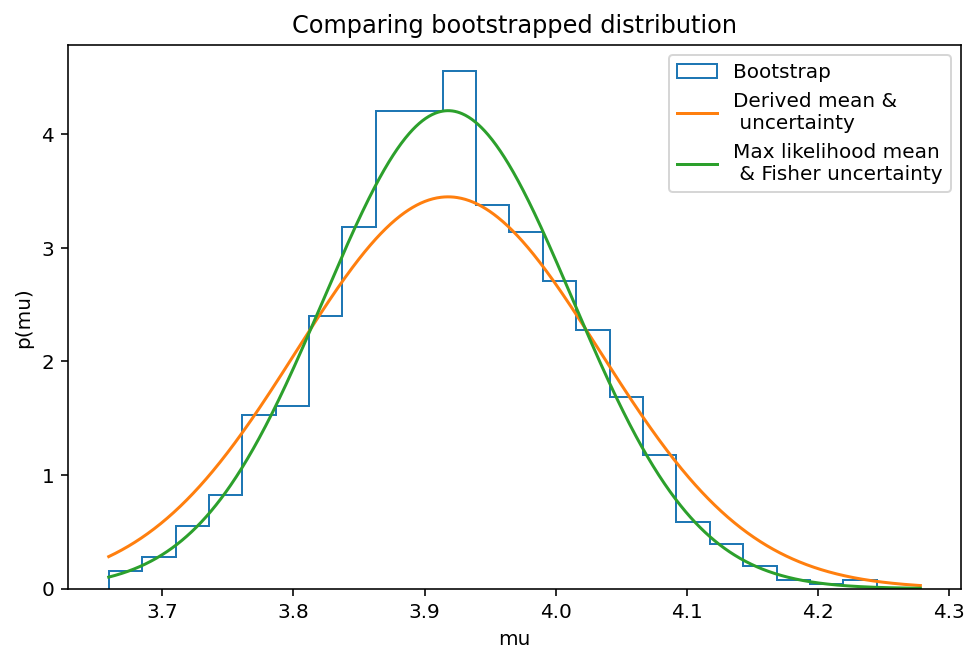

In [8]:
binW = 2*(np.percentile(muDist,75)-np.percentile(muDist,25))/len(muDist)**(1/3)
bins = np.arange(min(muDist),max(muDist),binW)


plt.figure(figsize=(8,5))
#Plot the histogram of the mean values
plt.hist(muDist,bins=bins,histtype="step",density=True,label='Bootstrap')

#Plot a gaussian with the derived mean and uncertanty from part 1
norm_mean = norm(loc=mean,scale=std_err_mean)
x_grid = np.linspace(min(muDist),max(muDist),1000)
plt.plot(x_grid,norm_mean.pdf(x_grid),label='Derived mean &\n uncertainty')


#Plot a gaussian with the derived mean and uncertanty
norm_mean = norm(loc=optimized_mu,scale=sigma)
x_grid = np.linspace(min(muDist),max(muDist),1000)
plt.plot(x_grid,norm_mean.pdf(x_grid),label='Max likelihood mean\n & Fisher uncertainty')


plt.title('Comparing bootstrapped distribution')
plt.ylabel('p(mu)')
plt.xlabel('mu')
plt.legend(loc='upper right')
plt.show()


While the gaussian and the histogram do look similar, I'd hesitate to say that they 'agree'. The histogram seems to overestimate the peak and underestimate the tails. This suggests that the bootstrapped datasets somehow have less uncertainty than that of the original distribution. However, when comparing the bootstrapped dataset with the max likelihood mean & fisher uncertainty, they are in significantly better agreement.

### Part 6

The Laplace distribution pdf is

$$p(x_i|\mu,b)={\displaystyle {\frac {1}{2b}}\exp \left(-{\frac {|x_i-\mu |}{b}}\right)}$$

Using the same steps as in part 2, we can make a log likelihood function.

$$ p(x|\mu,b) = \prod_i^N p(x_i|\mu,b)$$

$$ ln(p) = ln \left( \prod_i^N\frac{1}{2b} \exp \left( - \frac{|x_i - \mu|}{b} \right) \right) = \sum_i^N ln\left(\frac{1}{2b}\right) + ln\left(\exp \left( - \frac{|x_i - \mu|}{b } \right)\right) $$

$$ ln(p) = \sum_i^N ln\left(\frac{1}{2b}\right) - \sum_i^N \left( \frac{|x_i - \mu|}{b} \right) $$


In [9]:
def neg_laplace_lnLike(x,data=data):
    return -(np.sum(np.log(1/(2*x[1]))) - np.sum(np.abs(data-x[0]))/x[1])

In [10]:
guess=[1,1]
ret = minimize(neg_laplace_lnLike,guess).x
laplace_maxLike_mu = ret[0]
laplace_maxLike_b = ret[1]
print(f'The maximum likelihood parameters are mu={laplace_maxLike_mu}, b={laplace_maxLike_b}')


The maximum likelihood parameters are mu=4.077840289143004, b=89.90565922048917


### Part 7
For model comparisons using the AIC:

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

In [11]:
N = len(data)

#For the gaussian, we have uncertainties in our measurements, meaning only one parameter was needed to fit, mu
#Also, because I included constant terms, the functions used are valid (as long as I negate it)
gaussian_maxLike = -neg_ln_p(optimized_mu)
#print(gaussian_maxLike)
k_gaussian = 1
AIC_gaussian = -2*gaussian_maxLike + 2*k_gaussian + 2*k_gaussian*(k_gaussian+1)/(N-k_gaussian-1)
print(f'Gaussian AIC= {AIC_gaussian}')


#For the Laplacian, we fit for 2 parameters -> 2 degrees of freedom
laplace_maxLike = -neg_laplace_lnLike([laplace_maxLike_mu,laplace_maxLike_b])
#print(laplace_maxLike)
k_laplacian = 2
AIC_laplacian = -2*laplace_maxLike + 2*k_laplacian + 2*k_laplacian*(k_laplacian+1)/(N-k_laplacian-1)
print(f'Laplacian AIC= {AIC_laplacian}')


Gaussian AIC= 296.5565421011481
Laplacian AIC= 16.50766667555954


Laplacian model is heavily favored as per the book "...the [model] with the smallest AIC is the best model to select." (Ivezic et. al 134)

### Part 8

In [12]:
paramDist = []

for i in range(len(bootstrapData)):
    data = bootstrapData[i]
    
    paramDist.append(minimize(neg_laplace_lnLike,(4,80),args=(data)).x)
    
paramDist = np.array(paramDist)

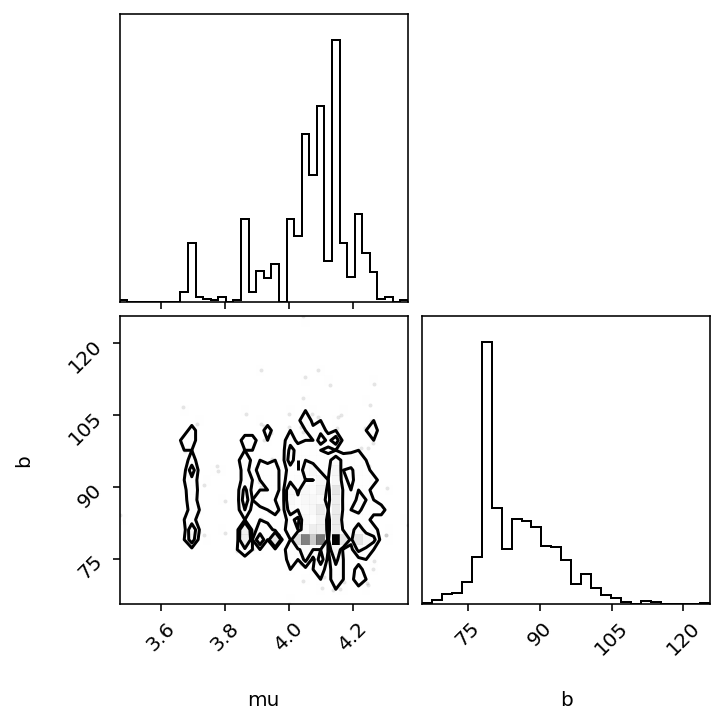

sigma_g for mu=0.08631035511321153
sigma_g for b=7.662531183645659


In [29]:
binW1 = 2*(np.percentile(paramDist[:,0],75)-np.percentile(paramDist[:,0],25))/len(paramDist[:,0])**(1/3)
bin1N = int((max(paramDist[:,0])-min(paramDist[:,0]))/binW1)


binW2 = 2*(np.percentile(paramDist[:,1],75)-np.percentile(paramDist[:,1],25))/len(paramDist[:,1])**(1/3)
bin2N = int((max(paramDist[:,1])-min(paramDist[:,1]))/binW2)

corner.corner(paramDist,bins=(bin1N,bin2N),labels=['mu','b'],levels=[0.68,0.95])
plt.show()

mu_sigmag = 0.7413 *(np.percentile(paramDist[:,0],75) - np.percentile(paramDist[:,0],25))
b_sigmag = 0.7413 *(np.percentile(paramDist[:,1],75) - np.percentile(paramDist[:,1],25))

print(f'sigma_g for mu={mu_sigmag}')
print(f'sigma_g for b={b_sigmag}')

I will say, the mu histogram looks pretty awful. It doesn't look like any sort of normal distribution and that bad data leaks into the 2d histogram too.  

### Part 9

In [14]:
!pip install numdifftools

In [26]:
import numdifftools as nd

H = nd.Hessian(neg_laplace_lnLike)([laplace_maxLike_mu, laplace_maxLike_b])
sigma_laplace = np.linalg.inv(H)**0.5
print(sigma_laplace[0,0])
print(sigma_laplace[1,1])

1.033591355263907
89.92315978006187


/var/folders/bb/_0rqpxpd2cl3kcsqv4vkt18h0000gq/T/ipykernel_20025/983982945.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(H)**0.5


Considering I'm getting NaNs on the off diagonal, I likely messed something up here, but I'm not sure what. Despite this, comparing the $\sigma_g$ values to those derived from the Hessian shows that both numbers are a about a factor of 10 from eachother. I'm really not sure what could be going wrong as my understanding of what is happening with the Hessian is lacking. Additionally, the marginalized histograms from the bootstrapped distributions are pretty bad and not well localized. All signs point to my likelihood function being wrong, but I can't see anything mathamatically wrong with it. 